**Потребуется версия sklern = 1.0.2.**

In [1]:
#!python -m pip install scikit-learn==1.0.2

# Описание проекта

Требуется разработать модель, которая по статистикам, собранным за последние пол года, сможет предсказать победу одной из команд.

In [2]:
import pandas as pd
import re
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer 

import phik
import numpy as np

import optuna
from optuna import Trial

import random

from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

- `p_id` - уникальный номер игрока
- `p_total_kills` - всего убийств
- `p_headshots` - всего хедшотов
- `p_total_deaths` - всего смертей
- `p_kd_ratio` - соотношение убийств к смертям
- `p_damage_per_round` - средний урон в раунде
- `p_grenade_damage_per_round` - средний урон гранатой в раунде 
- `p_maps_played` - количество сыгранных карт
- `p_rounds_played` - количество отыгранных раундов
- `p_kills_per_round` - среднее количество киллов в раунде
- `p_assists_per_round` - среднее количество асистов в раунде
- `p_deaths_per_round` - среднее количество смертей в раунде
- `p_saved_by_teammate_per_round` - сколько в среднем был спасен в раунде тимейтом
- `p_saved_teammates_per_round` - сколько в среднем спас в раунде тимейтов
- `p_rating` - рейтинг игрока
- `p_kill_death` - соотношение убийств к смертям
- `p_kill_round` - количество киллов в раунде
- `p_rounds_with_kills` - количество раундов с киллами 
- `p_kill_death_difference` - разница между киллами и смертями
- `p_total_opening_kills` - общее количество открытых киллов
- `p_total_opening_deaths` - общее количество открытых смертей
- `p_team_win_percent_after_first_kill` - процент победы команды после первого убийства 
- `p_first_kill_in_won_rounds` - количество первых убийств в выигранных раундах 
- `map_id` - уникальный номер карты
- `team_id` - уникальный номер команды 
- `map_name` - название карты
- `who_win` - кто выиграл: 0 - 1 команда; 1 - 2 команда(целевая переменная)

In [3]:
random.seed(40)
np.random.seed(40)

# Идеи

1. Попробовать вычислить позицию игрока, который по разговорам с опытными "ксэрами и ставочниками" делятся на 3 категории: авапер(много киллов, мало асистов, мало смертей, по сравнению с другими) - сейвит различное оружие, после инфы ждет и убивает, прикрывает команду; опорник, их 2(много смертей, много асистов, мало киллов) - помогает команде гранатами, идет в размен(его разменивают), пытается понять позицию игрока; рифлер, их 2(смертей меньше, чем у опорника, но больше, чем у авапера, среднее количество асистов между авапером и опорником, количество киллов между опорником и авапером) - он идет разменивать опорника, а также может быть опорником. Дополнительно в данных увидел, что есть игроки с 0 статистикой - это категория "новый игрок".

**Итог**: не получилось выявить, т.к. статистика у игроков в среднем одинаковая, т.к. игра постоянно меняется и каждый может друг друга.

2. Сформировать формулу, которая будет расчитывать скилл команды по количеству сыгранных и выигранных игр. 


**увеличил скор до 0.62** - модель до 6 пункта

3. Считаю, что название карты очень сильно может помочь в предсказании, т.к. на различных картах разный уровень игры, какие-то карты удобные для игры, какие-то нет. Обработать с помощью tf-idf, либо попробовать bert

**Увеличился скор с 0.50 до 0.56** - модель до 6 пункта

4. Выделить нужные признаки, просмотреть их зависимость с помощью phik корреляции

**Удалили ненужные признаки**

5. Логарифмировать признаки

**Увеличился скор с 0.57 до 0.58** модель до 6 пункта

6. Увидел, что в таблице players записываются данные как по временному ряду. Следовательно, желательно их агрегировать, т.е. брать среднюю по дамагу и т.д. в раунде, а не total статистики.

**скор 0.68**

7. Брать статистику за 10 процентов с округлением вверх игр, которые отыграли, чтобы была свежая статистика как играет команда.

**В процессе...**

**Про решения**

Как понимаю, то есть два варианта решения: 

1 - предсказывать победу на основании прошлых данных перед началом самого матча. Т.е. мы берем среднюю статистику за определенный период времени + информацию о карте и на основании этого делаем предсказание.

**Решаю по 1 варианту**


2 - предсказывать победу каждый раунда, что дает преимущество перед 1 вариантом, т.к. после первых раундов наберется статистика, и по ней мы можем уже делать прогноз на матч, как бы зная состояние игрока в день матча.


In [4]:
players = pd.read_csv('players_feats.csv')
train = pd.read_csv('train.csv')

In [5]:
train.duplicated().sum(), players.duplicated().sum()

(0, 0)

In [6]:
train.head()

,map_id,team1_id,team2_id,map_name,who_win
0,289,6665,7718,Ancient,0
1,715,4411,10577,Inferno,0
2,157,11251,9455,Nuke,1
3,524,4608,7532,Mirage,0
4,404,8637,6667,Overpass,1


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 713 entries, 0 to 712
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   map_id    713 non-null    int64 
 1   team1_id  713 non-null    int64 
 2   team2_id  713 non-null    int64 
 3   map_name  713 non-null    object
 4   who_win   713 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 28.0+ KB


In [8]:
train['map_name'].value_counts()

Mirage      118
Inferno     117
Nuke        109
Overpass    100
Ancient      99
Dust2        92
Vertigo      78
Name: map_name, dtype: int64

Самые популярные карты в турнире - Mirage, Inferno, Nuke, Overpass

interval columns not set, guessing: ['p1_id', 'p1_total_kills', 'p1_headshots', 'p1_total_deaths', 'p1_kd_ratio', 'p1_damage_per_round', 'p1_grenade_damage_per_round', 'p1_maps_played', 'p1_rounds_played', 'p1_kills_per_round', 'p1_assists_per_round', 'p1_deaths_per_round', 'p1_saved_by_teammate_per_round', 'p1_saved_teammates_per_round', 'p1_rating', 'p1_kill_death', 'p1_kill_round', 'p1_rounds_with_kills', 'p1_kill_death_difference', 'p1_total_opening_kills', 'p1_total_opening_deaths', 'p1_opening_kill_ratio', 'p1_opening_kill_rating', 'p1_team_win_percent_after_first_kill', 'p1_first_kill_in_won_rounds']


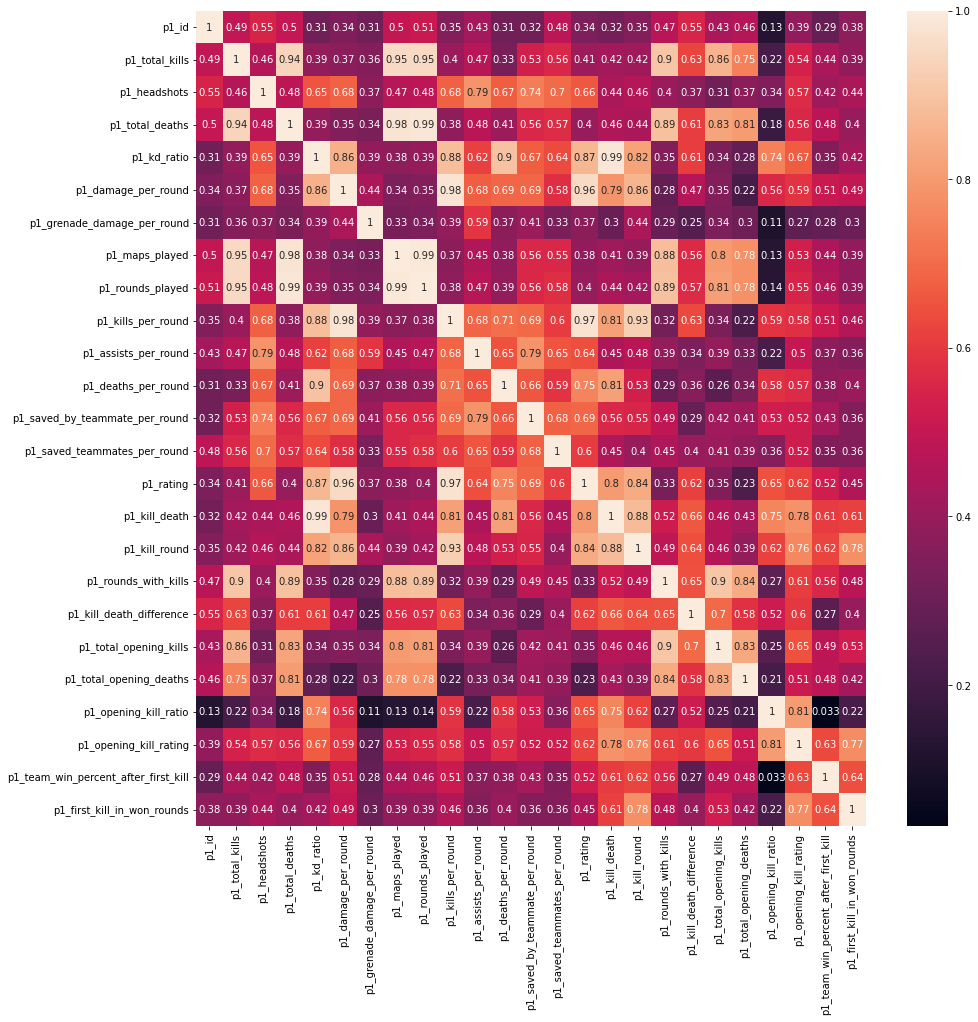

In [9]:
columns_name = []
for i in range(len(players.columns)):
    if len(re.findall('p1', players.columns[i])) != 0:
        columns_name.append(players.columns[i])

plt.figure(figsize=(15, 15));
sns.heatmap(players[columns_name].phik_matrix(), annot=True);

Имеем мультиколлинеарность, нужно думать, как убрать признаки для меньшей зависимости. Сразу могу сказать, что не нужны признаки, связанные с total результатами.

---

## Скилл команды по числу игр

In [10]:
team1 = train.groupby('team1_id', as_index=False)['who_win'].mean().sort_values('who_win', ascending=False).merge(
    train['team1_id'].value_counts().reset_index().rename(
        columns={'index': 'team1_id', 'team1_id': 'played'}), 
        on='team1_id').rename(columns={'team1_id': 'team_id'})

team1['who_win'] = team1['who_win'].apply(lambda x: 1 - x)

In [11]:
team2 = train.groupby('team2_id', as_index=False)['who_win'].mean().sort_values('who_win', ascending=False).merge(
    train['team2_id'].value_counts().reset_index().rename(
        columns={'index': 'team2_id', 'team2_id': 'played'}), 
        on='team2_id').rename(columns={'team2_id': 'team_id'})

In [12]:
team_info = team1.merge(team2, on=['team_id'], how='outer').fillna(0)

In [13]:
def sort_play(data):
    win = np.round(data['played_x'] * data['who_win_x']) + np.round(data['played_y'] * data['who_win_y'])
    
    played = data['played_x'] + data['played_y']
    
    
    data['played'] = played
    
    data['win'] = win / played
    return data


team_info = sort_play(team_info).drop(['who_win_x', 'who_win_y', 'played_x', 'played_y'], axis=1)

In [14]:
team_info

,team_id,played,win
0,11726,3.0,0.000000
1,6211,7.0,0.000000
2,9928,4.0,0.000000
3,4863,6.0,0.333333
4,7653,5.0,0.200000
...,...,...,...
56,11135,2.0,0.000000
57,11044,4.0,0.000000
58,10333,4.0,0.000000
59,9943,2.0,0.000000


Среди команд, которые находятся в топе по победам, отметил бы 9215, которая имеет большое кличество игр и среди них победила в 70 процентах.

Можно задуматься над тем, чтобы сделать фичу по статиске, сколько игр выиграла за последние пол года, чтобы понимать уровень команды

После раздумий над формулой понял, что можно считать то, какая команда лучше среди двух(либо же коэффициент более лучшего скила одной команды, по сравнению с другой:

Есть 2 команды. 1 отыграла 17 игр, победила в 10; 2 отыграла 30 игр, победила 18 раз. Какая команда лучше? 2 команда имеет больше опыта и такой же процент побед, как 1, следовательно, она должна быть лучше.

Для этого берем формулу: $\frac{X}{S}*K, $

где X - количество игр команды, S - сумма игр двух команд, K - процент побед

### Пример 1

In [15]:
result = pd.DataFrame({'Всего игр': [17, 30], 'Выигранные игры': [10, 18]})
result['Процент выигранных игр'] = result['Выигранные игры'] / result['Всего игр'] 
result['Покозатель игры'] = result['Всего игр'] / result['Всего игр'].sum() * result['Процент выигранных игр']
result

,Всего игр,Выигранные игры,Процент выигранных игр,Покозатель игры
0,17,10,0.588235,0.212766
1,30,18,0.600000,0.382979


Как видно, вторая команда лучше

### Пример 2

In [16]:
result = pd.DataFrame({'Всего игр': [17, 1], 'Выигранные игры': [8, 1]})
result['Процент выигранных игр'] = result['Выигранные игры'] / result['Всего игр'] 
result['Покозатель игры'] = result['Всего игр'] / result['Всего игр'].sum() * result['Процент выигранных игр']
result

,Всего игр,Выигранные игры,Процент выигранных игр,Покозатель игры
0,17,8,0.470588,0.444444
1,1,1,1.000000,0.055556


Не смотря на то, что 2 команда имеет 100 процентов побед, 1 команда лучше, т.к. отыграла намного больше игр.

---

## Сделать средние статистики по раундам по каждому игроку

---

In [17]:
players[(players['p1_id'] == 4954) & (players['p1_maps_played'] == 21)]

,p1_id,p1_total_kills,p1_headshots,p1_total_deaths,p1_kd_ratio,p1_damage_per_round,p1_grenade_damage_per_round,p1_maps_played,p1_rounds_played,p1_kills_per_round,...,p5_kill_death_difference,p5_total_opening_kills,p5_total_opening_deaths,p5_opening_kill_ratio,p5_opening_kill_rating,p5_team_win_percent_after_first_kill,p5_first_kill_in_won_rounds,team_id,map_name,map_id
576,4954,331,42.9,355,0.93,70.1,3.1,21,537,0.62,...,35,48,55,0.87,0.98,68.8,14.5,6665,Nuke,285
665,4954,334,44.0,358,0.93,69.5,2.8,21,548,0.61,...,38,50,58,0.86,0.96,70.0,13.5,6665,Nuke,123
714,4954,342,43.9,356,0.96,69.8,2.7,21,550,0.62,...,41,54,60,0.90,0.98,68.5,13.7,6665,Nuke,389
1325,4954,333,38.1,381,0.87,70.1,5.8,21,576,0.58,...,121,96,51,1.88,1.35,79.2,25.7,6665,Overpass,376
1455,4954,315,38.1,363,0.87,71.4,7.1,21,561,0.56,...,56,71,46,1.54,1.16,81.7,19.9,6665,Ancient,45
1463,4954,333,44.1,332,1.00,69.3,4.0,21,560,0.59,...,111,78,42,1.86,1.26,84.6,22.7,6665,Nuke,246


Интересно, нужно брать среднюю статистику по фичам, которые отвечают средний дамаг за раунд и т.д., потому что она более информативна. И так делать по каждому игроку.

Не беру все столбцы, т.к. total мне не нужны и ещё некоторые

In [18]:
# функция, которая выбирает нужные столбцы по игроку
def info_for_person(id_person, number_team: str):
    return players[[id_person +'_id',
                   id_person + '_kd_ratio', id_person + '_damage_per_round',
                   id_person + '_grenade_damage_per_round',
                   id_person + '_kills_per_round',
                   id_person + '_assists_per_round', id_person + '_deaths_per_round',  
                   id_person + '_saved_by_teammate_per_round', 
                   id_person + '_saved_teammates_per_round',
                   id_person + '_rating',  id_person + '_opening_kill_ratio', 
                   id_person + '_opening_kill_rating']].groupby(id_person + '_id', as_index=False).mean().rename(
    
            columns = {id_person +'_id':  id_person +'_id_team' + number_team, 
                       id_person + '_kd_ratio': id_person + '_kd_ratio_team' + number_team, 
                       id_person + '_damage_per_round': id_person + '_damage_per_round_team' + number_team,
                       id_person + '_grenade_damage_per_round': id_person + '_grenade_damage_per_round_team' + number_team,
                       id_person + '_kills_per_round': id_person + '_kills_per_round_team' + number_team,
                       id_person + '_assists_per_round': id_person + '_assists_per_round_team' + number_team, 
                       id_person + '_deaths_per_round': id_person + '_deaths_per_round_team' + number_team,  
                       id_person + '_saved_by_teammate_per_round': id_person + '_saved_by_teammate_per_round_team' + number_team, 
                       id_person + '_saved_teammates_per_round': id_person + '_saved_teammates_per_round_team' +  number_team,
                       id_person + '_rating': id_person + '_rating_team' + number_team,  
                       id_person + '_opening_kill_ratio': id_person + '_opening_kill_ratio_team' + number_team, 
                       id_person + '_opening_kill_rating': id_person + '_opening_kill_rating_team' + number_team})
    

In [19]:
# таблицы по каждому игроку, чтобы посчитать их среднюю игру, нестабильные игроки будут иметь статистику ниже, чем у стабильных
p1_team1 = info_for_person('p1', '1')
p2_team1 = info_for_person('p2', '1')
p3_team1 = info_for_person('p3', '1')
p4_team1 = info_for_person('p4', '1')
p5_team1 = info_for_person('p5', '1')

p1_team2 = info_for_person('p1', '2')
p2_team2 = info_for_person('p2', '2')
p3_team2 = info_for_person('p3', '2')
p4_team2 = info_for_person('p4', '2')
p5_team2 = info_for_person('p5', '2')

In [20]:
p1_team2.head()

,p1_id_team2,p1_kd_ratio_team2,p1_damage_per_round_team2,p1_grenade_damage_per_round_team2,p1_kills_per_round_team2,p1_assists_per_round_team2,p1_deaths_per_round_team2,p1_saved_by_teammate_per_round_team2,p1_saved_teammates_per_round_team2,p1_rating_team2,p1_opening_kill_ratio_team2,p1_opening_kill_rating_team2
0,29,1.047143,72.771429,3.842857,0.678571,0.124286,0.647143,0.094286,0.097143,1.052857,1.151429,0.957143
1,284,0.935890,64.901370,3.030137,0.587534,0.105616,0.630000,0.087397,0.080959,0.970274,0.874384,0.902329
2,356,0.913333,70.311111,6.611111,0.605556,0.134444,0.660000,0.097778,0.072222,0.977778,0.854444,0.936667
3,429,0.856374,70.473626,5.308791,0.592967,0.136154,0.692637,0.089890,0.057143,0.951758,0.747692,0.952088
4,555,0.950000,71.740000,7.620000,0.584000,0.162000,0.616000,0.122000,0.068000,1.050000,0.000000,0.284000


In [21]:
players_id = players[['p1_id', 'p2_id', 'p3_id', 'p4_id', 'p5_id', 'team_id', 'map_name', 'map_id']]

In [22]:
data = players_id.rename(columns={'team_id': 'team1_id'}).merge(train, on=['map_id', 'team1_id'])
data = data.drop('map_name_x', axis=1).rename(columns={'map_name_y': 'map_name'})

data = data.merge(players_id.rename(columns={'team_id': 'team2_id'}), on=['map_id', 'team2_id'], 
                            suffixes=('_team1', '_team2'))
data = data.drop(['map_id', 'map_name_team2'], axis=1).rename(columns={'map_name_team1': 'map_name'})

In [23]:
data = data.fillna(0)

In [24]:
data.head()

,p1_id_team1,p2_id_team1,p3_id_team1,p4_id_team1,p5_id_team1,team1_id,team2_id,map_name,who_win,p1_id_team2,p2_id_team2,p3_id_team2,p4_id_team2,p5_id_team2
0,4954,7412,9078,13843,15165,6665,7532,Ancient,1,5794,5796,7266,12781,14932
1,4954,7412,9078,13843,15165,6665,7532,Dust2,1,5794,5796,7266,12781,14932
2,7998,8918,11840,16947,18987,4608,9215,Dust2,1,11154,14390,14394,17861,20987
3,284,3741,3972,9816,19230,5995,4411,Mirage,0,8611,9278,9766,14218,16726
4,7998,8918,11840,16947,18987,4608,6665,Mirage,1,4954,7412,9078,13843,15165


Теперь буду присоединять среднюю стастистику по раундам всех матчей для каждого игрока, т.к. есть такие команды, которые поменяли игрока

In [25]:
team1_data = {'p1': p1_team1, 'p2': p2_team1, 'p3': p3_team1, 'p4': p4_team1, 'p5': p5_team1}
team2_data = {'p1': p1_team2, 'p2': p2_team2, 'p3': p3_team2, 'p4': p4_team2, 'p5': p5_team2}

In [26]:
for _id in ['p1', 'p2', 'p3', 'p4', 'p5']:
    data = data.merge(team1_data[_id], on=[_id + '_id_team1']).drop(_id + '_id_team1', axis=1)
    
for _id in ['p1', 'p2', 'p3', 'p4', 'p5']:
    data = data.merge(team2_data[_id], on=[_id + '_id_team2']).drop(_id + '_id_team2', axis=1)    

In [27]:
data.head()

,team1_id,team2_id,map_name,who_win,p1_kd_ratio_team1,p1_damage_per_round_team1,p1_grenade_damage_per_round_team1,p1_kills_per_round_team1,p1_assists_per_round_team1,p1_deaths_per_round_team1,...,p5_damage_per_round_team2,p5_grenade_damage_per_round_team2,p5_kills_per_round_team2,p5_assists_per_round_team2,p5_deaths_per_round_team2,p5_saved_by_teammate_per_round_team2,p5_saved_teammates_per_round_team2,p5_rating_team2,p5_opening_kill_ratio_team2,p5_opening_kill_rating_team2
0,6665,7532,Ancient,1,0.868916,67.775904,5.146988,0.565422,0.152651,0.652289,...,80.84,3.47,0.7655,0.128,0.6535,0.087,0.122,1.154,1.104,0.994
1,6665,7532,Dust2,1,0.868916,67.775904,5.146988,0.565422,0.152651,0.652289,...,80.84,3.47,0.7655,0.128,0.6535,0.087,0.122,1.154,1.104,0.994
2,6665,7532,Dust2,1,0.868916,67.775904,5.146988,0.565422,0.152651,0.652289,...,80.84,3.47,0.7655,0.128,0.6535,0.087,0.122,1.154,1.104,0.994
3,6665,7532,Mirage,1,0.868916,67.775904,5.146988,0.565422,0.152651,0.652289,...,80.84,3.47,0.7655,0.128,0.6535,0.087,0.122,1.154,1.104,0.994
4,6665,7532,Ancient,0,0.868916,67.775904,5.146988,0.565422,0.152651,0.652289,...,80.84,3.47,0.7655,0.128,0.6535,0.087,0.122,1.154,1.104,0.994


In [28]:
data

,team1_id,team2_id,map_name,who_win,p1_kd_ratio_team1,p1_damage_per_round_team1,p1_grenade_damage_per_round_team1,p1_kills_per_round_team1,p1_assists_per_round_team1,p1_deaths_per_round_team1,...,p5_damage_per_round_team2,p5_grenade_damage_per_round_team2,p5_kills_per_round_team2,p5_assists_per_round_team2,p5_deaths_per_round_team2,p5_saved_by_teammate_per_round_team2,p5_saved_teammates_per_round_team2,p5_rating_team2,p5_opening_kill_ratio_team2,p5_opening_kill_rating_team2
0,6665,7532,Ancient,1,0.868916,67.775904,5.146988,0.565422,0.152651,0.652289,...,80.840000,3.470000,0.765500,0.128000,0.6535,0.087000,0.122000,1.154000,1.104,0.994
1,6665,7532,Dust2,1,0.868916,67.775904,5.146988,0.565422,0.152651,0.652289,...,80.840000,3.470000,0.765500,0.128000,0.6535,0.087000,0.122000,1.154000,1.104,0.994
2,6665,7532,Dust2,1,0.868916,67.775904,5.146988,0.565422,0.152651,0.652289,...,80.840000,3.470000,0.765500,0.128000,0.6535,0.087000,0.122000,1.154000,1.104,0.994
3,6665,7532,Mirage,1,0.868916,67.775904,5.146988,0.565422,0.152651,0.652289,...,80.840000,3.470000,0.765500,0.128000,0.6535,0.087000,0.122000,1.154000,1.104,0.994
4,6665,7532,Ancient,0,0.868916,67.775904,5.146988,0.565422,0.152651,0.652289,...,80.840000,3.470000,0.765500,0.128000,0.6535,0.087000,0.122000,1.154000,1.104,0.994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708,9996,9799,Overpass,0,1.093571,78.871429,5.496429,0.699286,0.136071,0.641429,...,78.325000,5.725000,0.677500,0.127500,0.6800,0.092500,0.087500,1.070000,0.000,0.000
709,4773,10894,Mirage,0,0.977600,73.564000,5.956000,0.622800,0.170000,0.640400,...,76.471429,1.285714,0.741429,0.111429,0.6100,0.091429,0.138571,1.111429,0.000,0.000
710,4773,10894,Nuke,0,0.977600,73.564000,5.956000,0.622800,0.170000,0.640400,...,76.471429,1.285714,0.741429,0.111429,0.6100,0.091429,0.138571,1.111429,0.000,0.000
711,7653,10894,Mirage,1,0.928000,73.180000,4.820000,0.640000,0.140000,0.696000,...,76.471429,1.285714,0.741429,0.111429,0.6100,0.091429,0.138571,1.111429,0.000,0.000


### Способ добавления фичи, которая будет показывать, какая команда лучше по прошлым данным

Успеха не принесло :(

In [29]:
# def k_best(data):
#     data['k_team1'] = data['played_team1'] / (data['played_team1'] + data['played_team2']) * data['win_team1']
#     data['k_team2'] = data['played_team2'] / (data['played_team1'] + data['played_team2']) * data['win_team2']
#     return data

In [30]:
# data = data.merge(team_info.rename(columns={'team_id': 'team1_id'}), on=['team1_id']).merge(
#                             team_info.rename(columns={'team_id': 'team2_id'}), on=['team2_id'], suffixes=['_team1', '_team2'])

In [31]:
# data = k_best(data)

In [32]:
# data['the_best'] = data.apply(lambda x: 'one_the_best' if x['k_team1'] > x['k_team2'] else 'two_the_best', axis=1)

Решил добавить дополнительную информацию, которую смог - рейтинг карт в cs go, чтобы увеличить информацию про карту, т.к. она играет важную роль. П/опросили 8 членов редакции расположить все соревновательные локации из игры от лучшей к худшей. За первое место в рейтинге карта получала 10 баллов, за второе – 9 и так далее. 
https://cyber.sports.ru/tribuna/blogs/cs_is_love_cs_is_life/3027104.html

**Улучшить скор не помогло**

In [33]:
# rating_maps = pd.DataFrame({'map_name': ['Inferno', 'Overpass', 'Nuke', 'Mirage', 'Dust2', 'Vertigo', 'Ancient'],
#                             'rating_map': [58, 55, 54, 48, 44, 33, 25]}, index=range(7))

# Обучение моделей

In [34]:
data.head()

,team1_id,team2_id,map_name,who_win,p1_kd_ratio_team1,p1_damage_per_round_team1,p1_grenade_damage_per_round_team1,p1_kills_per_round_team1,p1_assists_per_round_team1,p1_deaths_per_round_team1,...,p5_damage_per_round_team2,p5_grenade_damage_per_round_team2,p5_kills_per_round_team2,p5_assists_per_round_team2,p5_deaths_per_round_team2,p5_saved_by_teammate_per_round_team2,p5_saved_teammates_per_round_team2,p5_rating_team2,p5_opening_kill_ratio_team2,p5_opening_kill_rating_team2
0,6665,7532,Ancient,1,0.868916,67.775904,5.146988,0.565422,0.152651,0.652289,...,80.84,3.47,0.7655,0.128,0.6535,0.087,0.122,1.154,1.104,0.994
1,6665,7532,Dust2,1,0.868916,67.775904,5.146988,0.565422,0.152651,0.652289,...,80.84,3.47,0.7655,0.128,0.6535,0.087,0.122,1.154,1.104,0.994
2,6665,7532,Dust2,1,0.868916,67.775904,5.146988,0.565422,0.152651,0.652289,...,80.84,3.47,0.7655,0.128,0.6535,0.087,0.122,1.154,1.104,0.994
3,6665,7532,Mirage,1,0.868916,67.775904,5.146988,0.565422,0.152651,0.652289,...,80.84,3.47,0.7655,0.128,0.6535,0.087,0.122,1.154,1.104,0.994
4,6665,7532,Ancient,0,0.868916,67.775904,5.146988,0.565422,0.152651,0.652289,...,80.84,3.47,0.7655,0.128,0.6535,0.087,0.122,1.154,1.104,0.994


In [35]:
count_vect = TfidfVectorizer()

text_vector = pd.DataFrame(count_vect.fit_transform(data['map_name']).toarray(), columns=count_vect.get_feature_names_out())

data = data.join(text_vector).drop(['map_name', 'team1_id', 'team2_id'], axis=1)

In [36]:
features = data.drop('who_win', axis=1)

target = data['who_win']

In [37]:
# выборка для обучения лучшей модели
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [38]:
numeric = features_train.drop(['ancient', 'dust2', 'inferno', 'mirage', 'nuke', 'overpass', 'vertigo'], axis=1).columns

# логарифмирую признаки для линейной модели
features_train[numeric] = np.log1p(features_train[numeric])
features_test[numeric] = np.log1p(features_test[numeric])

scaler = StandardScaler()
standard_scaler = scaler.fit(features_train[numeric])

features_train[numeric] = standard_scaler.transform(features_train[numeric])
features_test[numeric] = standard_scaler.transform(features_test[numeric])

### Baseline

In [39]:
parameters = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1'],
    'max_iter': [400, 600, 800, 1000]
}


rfc = LogisticRegression(solver='saga')
lr_gs = GridSearchCV(rfc, parameters, cv=10, n_jobs=-1, scoring='roc_auc', error_score='raise')
lr_gs.fit(features_train, target_train)

GridSearchCV(cv=10, error_score='raise',
             estimator=LogisticRegression(solver='saga'), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'max_iter': [400, 600, 800, 1000], 'penalty': ['l1']},
             scoring='roc_auc')

In [40]:
lr_gs.best_score_, lr_gs.best_params_

(0.6609125310173698, {'C': 10, 'max_iter': 800, 'penalty': 'l1'})

In [41]:
prediction = lr_gs.predict_proba(features_test)[:, 1]
print('ROC-AUC:', roc_auc_score(target_test, prediction))

ROC-AUC: 0.700392156862745


Прекрасный результат достиг, сравню с деревянными моделями

In [42]:
lr = LogisticRegression(C=10, max_iter=800, penalty='l1', solver='saga')

lr.fit(features_train, target_train)

LogisticRegression(C=10, max_iter=800, penalty='l1', solver='saga')

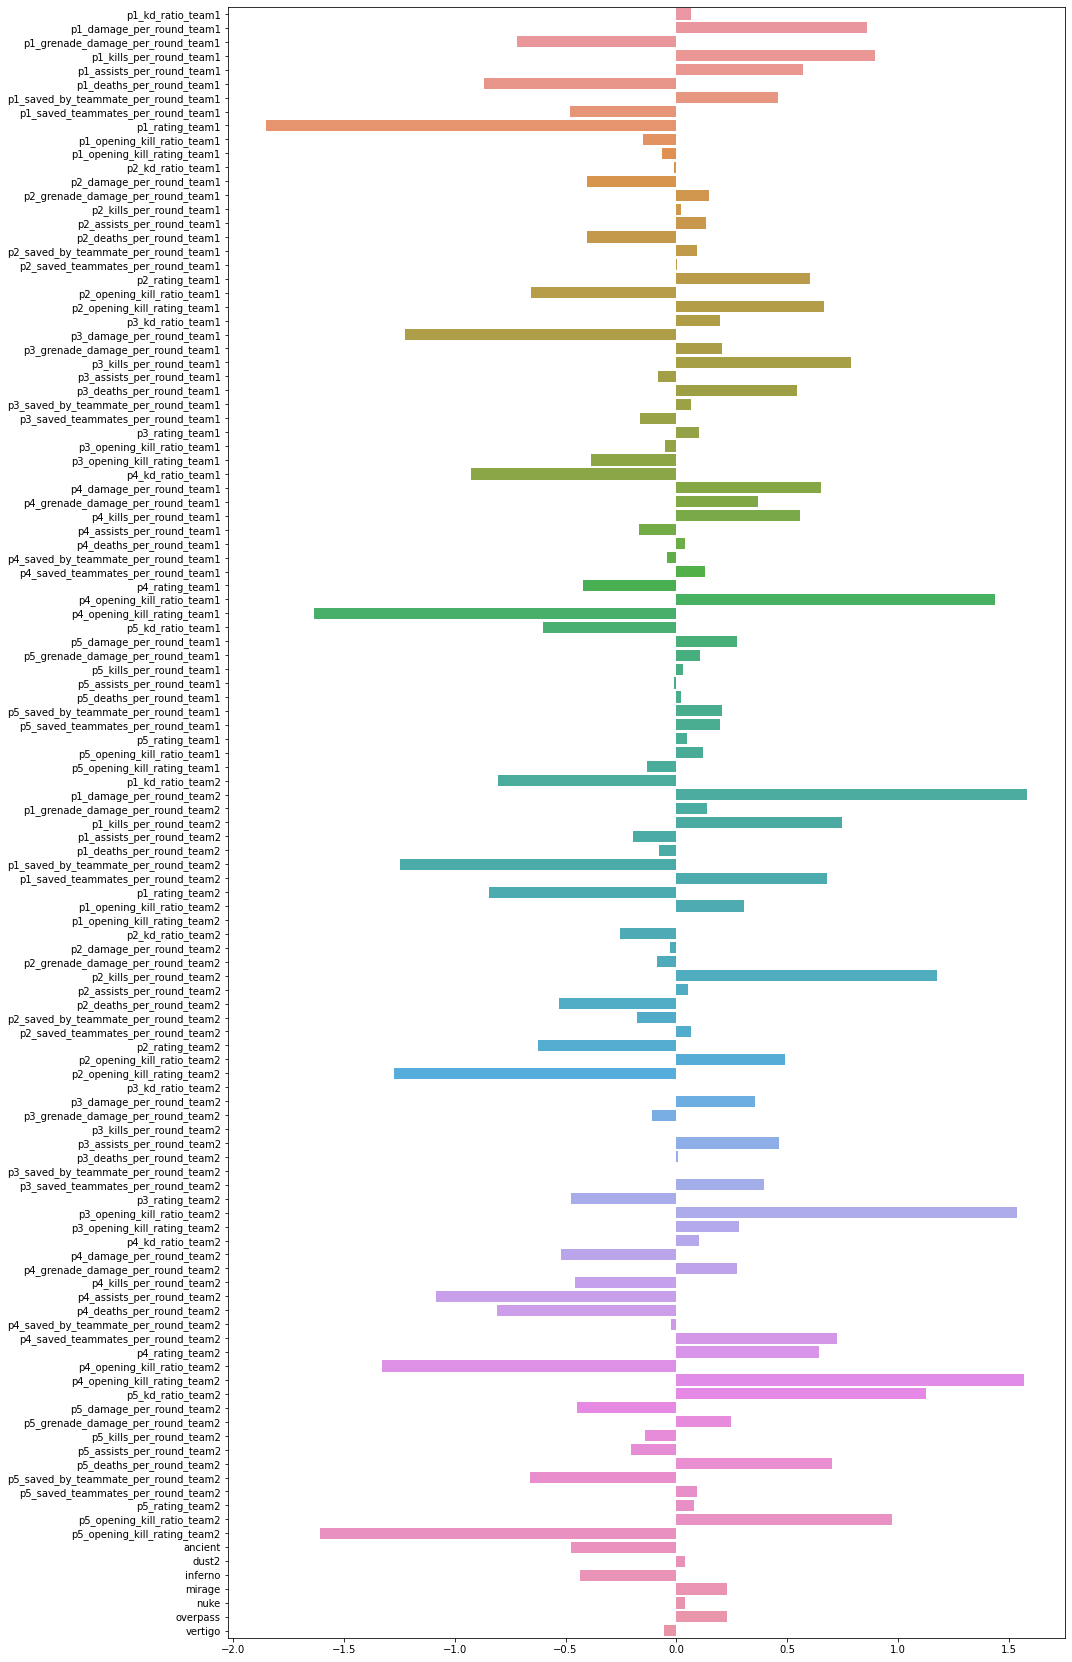

In [43]:
plt.figure(figsize=(15, 30));
sns.barplot(x=lr.coef_[0], y=features_train.columns);

Есть фичи по игрокам, которые показывают высокий вес, не удаляю те, которые имею маленький вес, т.к. в общем виде дают лучшие результаты

In [44]:
forest = RandomForestClassifier()

forest.fit(features_train, target_train)
pred = forest.predict_proba(features_test)[:, 1]
print(roc_auc_score(target_test, pred))

0.6289215686274511


Лесная модель показывает себя похуже, но попробуем исправить правильным нахождением гиперпараметров, а также применением градиентного бустинга

---

## Улучшение моделей

### RandomForest

In [45]:
parameters = {
    'n_estimators': [1000, 1200, 1500],
    'max_depth': [6, 12, 18]
}


rfc = RandomForestClassifier(max_features='sqrt',
                             class_weight='balanced')
gs = GridSearchCV(rfc, parameters, cv=10, n_jobs=-1, scoring='roc_auc')
gs.fit(features_train, target_train)

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              max_features='sqrt'),
             n_jobs=-1,
             param_grid={'max_depth': [6, 12, 18],
                         'n_estimators': [1000, 1200, 1500]},
             scoring='roc_auc')

In [46]:
gs.best_score_, gs.best_params_

(0.6009590570719603, {'max_depth': 18, 'n_estimators': 1000})

In [47]:
prediction = gs.predict_proba(features_test)[:, 1]
print('ROC-AUC:', roc_auc_score(target_test, prediction))

ROC-AUC: 0.6447058823529411


Результат получается хуже, чем у логрег модели, попробую бустинг

### LGBM

In [48]:
parameters = {
    'n_estimators': [1000, 1200],
    'max_depth': [12, 18],
    'learning_rate': [0.01],
    'num_leaves': [12, 24]
}


lgbm = LGBMClassifier()
gs = GridSearchCV(lgbm, parameters, cv=10, n_jobs=-1, scoring='roc_auc')
gs.fit(features_train, target_train)

GridSearchCV(cv=10, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01], 'max_depth': [12, 18],
                         'n_estimators': [1000, 1200], 'num_leaves': [12, 24]},
             scoring='roc_auc')

In [49]:
gs.best_score_, gs.best_params_

(0.6135058933002482,
 {'learning_rate': 0.01,
  'max_depth': 12,
  'n_estimators': 1200,
  'num_leaves': 12})

In [50]:
prediction = gs.predict_proba(features_test)[:, 1]
print('ROC-AUC:', roc_auc_score(target_test, prediction))

ROC-AUC: 0.6623529411764706


Неплохой результат, но логрег показывает намного лучше в кроссвалидации.

In [51]:
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 11, 13),
        'n_estimators': trial.suggest_int('n_estimators', 900, 1100, 20),
        'num_leaves': trial.suggest_int('num_leaves', 20, 24),
        'learning_rate': [0.01]
    }

    
    # задаём модели требуемые параметры    
    model=LGBMClassifier(**params)

    # проводим кросс-валидацию  
    score = cross_val_score(estimator=model, X=features_train, y=target_train, 
                            scoring='roc_auc', cv=10, n_jobs=-1)

    
    return score.mean()


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2022-12-04 22:46:00,909] A new study created in memory with name: no-name-23a9a7ae-ef27-449e-9b3f-59cb2c083733
[I 2022-12-04 22:46:03,200] Trial 0 finished with value: 0.6051978908188586 and parameters: {'max_depth': 11, 'n_estimators': 940, 'num_leaves': 23}. Best is trial 0 with value: 0.6051978908188586.
[I 2022-12-04 22:46:05,405] Trial 1 finished with value: 0.6080486972704715 and parameters: {'max_depth': 13, 'n_estimators': 940, 'num_leaves': 20}. Best is trial 1 with value: 0.6080486972704715.
[I 2022-12-04 22:46:07,730] Trial 2 finished with value: 0.6095533498759305 and parameters: {'max_depth': 12, 'n_estimators': 1000, 'num_leaves': 21}. Best is trial 2 with value: 0.6095533498759305.
[I 2022-12-04 22:46:10,251] Trial 3 finished with value: 0.6042099875930521 and parameters: {'max_depth': 13, 'n_estimators': 1080, 'num_leaves': 21}. Best is trial 2 with value: 0.6095533498759305.
[I 2022-12-04 22:46:12,405] Trial 4 finished with value: 0.6049478908188586 and parameters: 

In [52]:
study.best_params, study.best_value

({'max_depth': 12, 'n_estimators': 920, 'num_leaves': 21}, 0.6146383374689826)

In [53]:
lgbm = LGBMClassifier(learning_rate=0.01,
                     max_depth=12,
                     n_estimators=1020,
                     num_leaves=24)

lgbm.fit(features_train, target_train)
pred = lgbm.predict_proba(features_test)[:, 1]
print('ROC-AUC:', roc_auc_score(target_test, pred))

ROC-AUC: 0.6623529411764706


Логистическая регрессия все равно показывает себя лучше, даже с догонкой гиперпараметров бустинга

In [54]:
test = pd.read_csv('test.csv', index_col=[0]).reset_index(drop=True)

In [57]:
# функция для предсказаний
def predict_result(data, players_id, team1_data, team2_data, count_vect, standard_scaler):
    data = players_id.rename(columns={'team_id': 'team1_id'}).merge(data, on=['map_id', 'team1_id'])
    data = data.drop('map_name_x', axis=1).rename(columns={'map_name_y': 'map_name'})

    data = data.merge(players_id.rename(columns={'team_id': 'team2_id'}), on=['map_id', 'team2_id'], 
                            suffixes=('_team1', '_team2'))
    data = data.drop(['map_id', 'map_name_team2'], axis=1).rename(columns={'map_name_team1': 'map_name'}).fillna(0)
    
    for _id in ['p1', 'p2', 'p3', 'p4', 'p5']:
        data = data.merge(team1_data[_id], on=[_id + '_id_team1']).drop(_id + '_id_team1', axis=1)
    
    for _id in ['p1', 'p2', 'p3', 'p4', 'p5']:
        data = data.merge(team2_data[_id], on=[_id + '_id_team2']).drop(_id + '_id_team2', axis=1) 
    
    text_vector = pd.DataFrame(count_vect.fit_transform(data['map_name']).toarray(), columns=count_vect.get_feature_names_out())

    data = data.join(text_vector).drop(['map_name', 'team1_id', 'team2_id'], axis=1)
    
    data[numeric] = np.log1p(data[numeric])
    
    data[numeric] = standard_scaler.transform(data[numeric])

    prediction = lr_gs.predict_proba(data)[:, 1]
    
    return prediction

In [58]:
predict_test = np.where(predict_result(test, players_id, team1_data, team2_data, count_vect, standard_scaler) > 0.5, 1, 0)
predict_test_probability = predict_result(test, players_id, team1_data, team2_data, count_vect, standard_scaler)

In [59]:
# файл с предсказаниями вероятностей
pd.DataFrame(predict_test_probability, columns=['who_win_probability']).to_csv('who_win_probability.csv')
# файл с предсказаниями 0/1
pd.DataFrame(predict_test, columns=['who_win']).to_csv('who_win.csv')

<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 3px solid indigo; padding: 15px"> 
<h2 align="center"> Вывод<a class="tocSkip"> </h2>
По итогам данного проекта имею такие результаты: 


    - LogReg - 0.7
    - RandomForest - 0.646
    - LGBM - 0.662
    
Лучшая модель - логистическая регрессия. Проектом доволен, он мне понравился, узнал чуть больше о cs go, а также попробовал новые способы предобработки данных, которые буду внедрять в следующие проекты. Плюсом будет порешать такую задачку, только связанной с dota2.